In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import sign

def xi_generate(x_range,e):
    bin=len(x_range)
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=abs(x_range[i]-x_range[j])/e
    return C

def bisection(fun, a, b, stepmax, tol):
    if abs(fun(a)) <= tol: return a
    if abs(fun(b)) <= tol: return b
    if sign(fun(a)) * sign(fun(b)) > 0: return print("bad section")
    for step in range(1, stepmax+1):
        c = (a + b) / 2
        if sign(fun(c)) == 0: return c
        if abs((b - a)/2) < tol: return (b + a) / 2
        if sign(fun(c)) * sign(fun(a)) < 0:
            b = c
        else:
            a = c
    return (a + b) / 2  

def tmp_generator(gamma_dict,num,q_dict,q_num,L):
    bin=gamma_dict[0].shape[0]
    if q_num<=0:
        q=np.matrix(np.ones((bin,bin)))
    else:
        q=q_dict[q_num]
    tmp_gamma=np.zeros((bin,bin))
    tmp_q=np.zeros((bin,bin))
    for i in range(bin):
        for j in range(bin):
            tmp_gamma[i,j]=q.item(i,j)*gamma_dict[num-1].item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
            tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
    return np.matrix(tmp_gamma),np.matrix(tmp_q)     

def Gaussian_pdf(x,name,para):
    mu=para[name+'_mean']
    sigma=para[name+'_sd']
    return math.exp(((x-mu)/sigma)**2*(-1/2))/(sigma*math.sqrt(2*math.pi))  
def empirical_distribution(sub,dist):
    bin=dist['bin']
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==i] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

def data_generation(num,para):
    df=pd.DataFrame(columns=['X', 'S'])
    for ignore in range(num):
        if np.random.random()<para['s_0']:
            X=np.floor((np.random.normal(para['X_0_mean'],para['X_0_sd'],size=[1])-para['horizen'][0])/para['width'])
            sample=[X,'0']
        else:
            X=np.floor((np.random.normal(para['X_1_mean'],para['X_1_sd'],size=[1])-para['horizen'][0])/para['width'])
            sample=[X,'1']
        df=pd.concat([df, pd.DataFrame(sample,index=['X','S']).T], ignore_index=True)
    df['W']=1
    df['X']=df['X'].astype('int64')  
    return df

def samples_groupby(data):
    # for better complexity
    df=data.groupby(by=['X','S'],as_index=False).sum()
    return df[df['W']!=0]

def projection(df,coupling_matrix):
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=['X','S','W'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        rows=np.nonzero(coupling[orig[0],:])[0]
        sub=pd.DataFrame(columns=['X','W'],index=rows)
        sub['X']=rows
        sub['W']=coupling[orig[0],rows]/(sum(coupling[orig[0],rows])+0.0001)*orig[2]
        sub['S']=orig[1]
        df_t=pd.concat([df_t, samples_groupby(sub)], ignore_index=True)
    return df_t

In [2]:
para = dict()
para['X_0_mean']=-8
para['X_0_sd']=7
para['X_1_mean']=2
para['X_1_sd']=3
para['X_t_mean']=-10
para['X_t_sd']=5
para['s_0']=0.6
para['s_1']=0.4
para['horizen']=[-30,20]
para['width']=10
bin=int((para['horizen'][1]-para['horizen'][0])/para['width'])

x_range=np.arange(para['horizen'][0],para['horizen'][1],para['width'])
dist = dict(zip(['horizen','width','bin','x_range'],[para['horizen'],para['width'],bin,x_range]))
dist['x_0']=[Gaussian_pdf(x,'X_0',para)*para['width'] for x in x_range]
dist['x_1']=[Gaussian_pdf(x,'X_1',para)*para['width'] for x in x_range]
dist['x']=[dist['x_0'][i]*para['s_0']+dist['x_1'][i]*para['s_1'] for i in range(bin)]
dist['t_x']=[Gaussian_pdf(x,'X_t',para)*para['width'] for x in x_range] 
dist['v']=[(dist['x_0'][i]-dist['x_1'][i])/dist['x'][i] for i in range(bin)]

e=0.01
xi=xi_generate([*range(bin)],e)

bbm1=np.matrix(np.ones(bin)).T
px=np.matrix(dist['x']).T
ptx=np.matrix(dist['t_x']).T
V=np.matrix(dist['v']).T
I=np.where(~(V==0))[0].tolist() # \overline{\supp(X)}

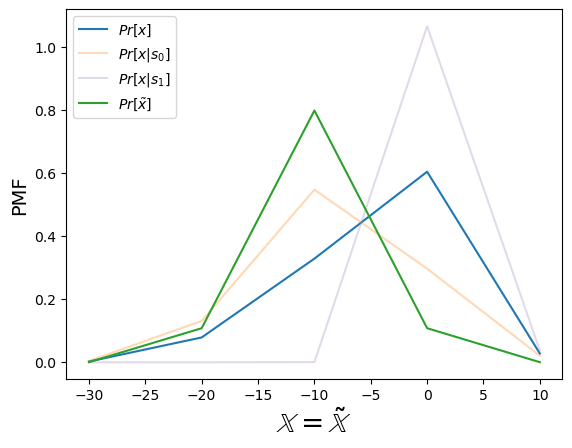

In [3]:
plt.plot(x_range,dist['x'],label=r'$Pr[x]$',color='tab:blue')
plt.plot(x_range,dist['x_0'],label=r'$Pr[x|s_0]$',alpha=0.3,color='tab:orange')
plt.plot(x_range,dist['x_1'],label=r'$Pr[x|s_1]$',alpha=0.3,color='#9f86c0')
plt.plot(x_range,dist['t_x'],label=r'$Pr[\tilde{x}]$',color='tab:green')
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'$\mathbb{X}=\tilde{\mathbb{X}}$',fontsize=20)
plt.legend()
plt.savefig('C:/Users/zhouq/Downloads/SourceTarget_example.pdf',bbox_inches = 'tight')

In [24]:
sum(dist['x'])

1.0412023656489513

In [23]:
sum(dist['t_x'])

1.0143837477586772

In [22]:
gamma_classic[5000].T@ bbm1

matrix([[2.67660452e-04],
        [1.07981933e-01],
        [7.97884561e-01],
        [1.07981933e-01],
        [2.67660452e-04]])

In [17]:
# simplist
gamma_classic=dict()
gamma_classic[0]=np.matrix(np.exp(-xi)+1.0e-3)
for repeat in range(5000):
    gamma_classic[1+2*repeat]=np.matrix(np.diag((px/(gamma_classic[2*repeat] @ bbm1)).A1))@gamma_classic[2*repeat] #np.diag(dist['x']/sum(gamma_classic.T))@gamma_classic
    gamma_classic[2+2*repeat]=gamma_classic[1+2*repeat]@np.matrix(np.diag((ptx/(gamma_classic[1+2*repeat].T @ bbm1)).A1))

In [6]:
# our method
gamma_dict=dict()
gamma_dict[0]=np.matrix(np.exp(-xi)+1.0e-3)
gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
# step 3
J=np.where(~((gamma_dict[2].T @ V).A1 ==0))[0].tolist()
nu=np.zeros(bin)
gamma_dict[3]=np.copy(gamma_dict[2])
for j in J:
    fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
    nu = bisection(fun, -10,10, stepmax = 25, tol = 1.0e-3)
    for i in I:
        gamma_dict[3][i,j]=np.exp(nu*V.item(i))*gamma_dict[2].item(i,j)
gamma_dict[3]=np.matrix(gamma_dict[3])

#=========================
L=3
q_dict=dict()
for loop in range(1,500):
    tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
    gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

    tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
    gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

    # step 3
    tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
    J=np.where(~((abs(np.matrix(tmp).T @ V).A1)==0))[0].tolist()
    gamma_dict[loop*L+3]=np.copy(tmp)
    for j in J:
        fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
        nu = bisection(fun, -50,50, stepmax = 25, tol = 1.0e-4)
        for i in I:
            gamma_dict[loop*L+3][i,j]=np.exp(nu*V.item(i))*tmp.item(i,j)
    gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

In [326]:
gamma_dict[0]==0

matrix([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])

In [403]:
z=1
sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)

3.6296001814173855e-07

In [7]:
M=5000
data=samples_groupby(data_generation(M,para))

In [438]:
classic=gamma_classic[len(gamma_classic)-1]

In [436]:
new=gamma_dict[len(gamma_dict)-1]

In [441]:
sum(abs((new-classic) @ bbm1))

matrix([[0.00049444]])

In [442]:
sum(abs((new-classic).T @ bbm1))

matrix([[1.17234188e-07]])

In [443]:
sum(abs((new-classic).T @ V))

matrix([[0.23976878]])

In [8]:
data_revised_1=projection(data,gamma_classic[len(gamma_classic)-1])
data_revised_2=projection(data,gamma_dict[len(gamma_dict)-1])

In [9]:
dist_original=dict()
dist_original['x']=empirical_distribution(data,dist)
dist_original['x_0']=empirical_distribution(data[data['S']=='0'],dist)
dist_original['x_1']=empirical_distribution(data[data['S']=='1'],dist)

dist_project_1=dict()
dist_project_1['x']=empirical_distribution(data_revised_1,dist)
dist_project_1['x_0']=empirical_distribution(data_revised_1[data_revised_1['S']=='0'],dist)
dist_project_1['x_1']=empirical_distribution(data_revised_1[data_revised_1['S']=='1'],dist)

dist_project_2=dict()
dist_project_2['x']=empirical_distribution(data_revised_2,dist)
dist_project_2['x_0']=empirical_distribution(data_revised_2[data_revised_2['S']=='0'],dist)
dist_project_2['x_1']=empirical_distribution(data_revised_2[data_revised_2['S']=='1'],dist)

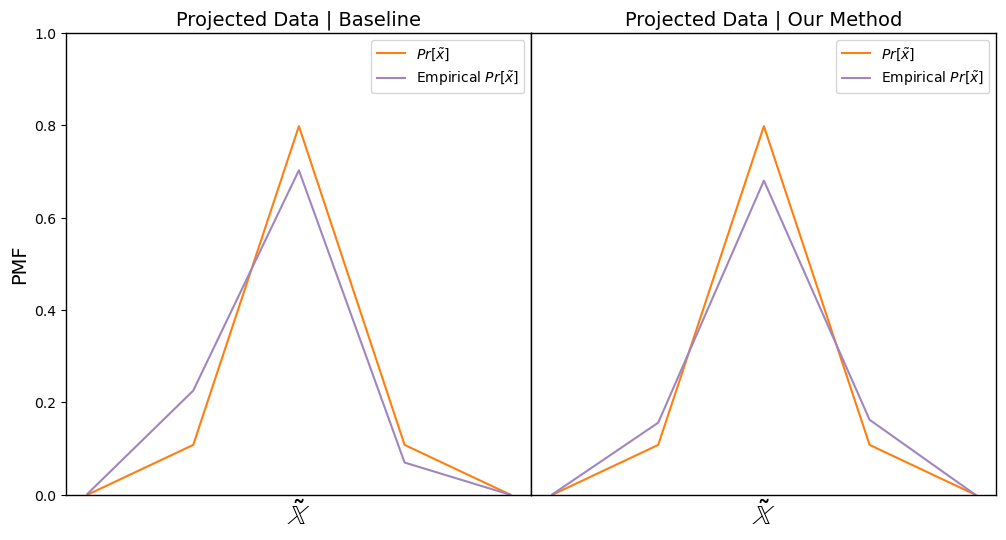

In [12]:
ymax=1
fig = plt.figure(figsize=(12,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
dist_tmp=dist_project_1
plt.plot(x_range,dist['t_x'],label=r'$Pr[\tilde{x}]$',color='tab:orange')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $Pr[\tilde{x}]$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend()
plt.xticks([])
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'$\tilde{\mathbb{X}}$',fontsize=20)
plt.title('Projected Data | Baseline',fontsize=14)
ax=plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
dist_tmp=dist_project_2
plt.plot(x_range,dist['t_x'],label=r'$Pr[\tilde{x}]$',color='tab:orange')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $Pr[\tilde{x}]$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend()
plt.yticks([])
plt.xticks([])
plt.xlabel(r'$\tilde{\mathbb{X}}$',fontsize=20)
plt.title('Projected Data | Our Method',fontsize=14)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
plt.savefig('C:/Users/zhouq/Downloads/lambda_example.pdf',bbox_inches = 'tight')

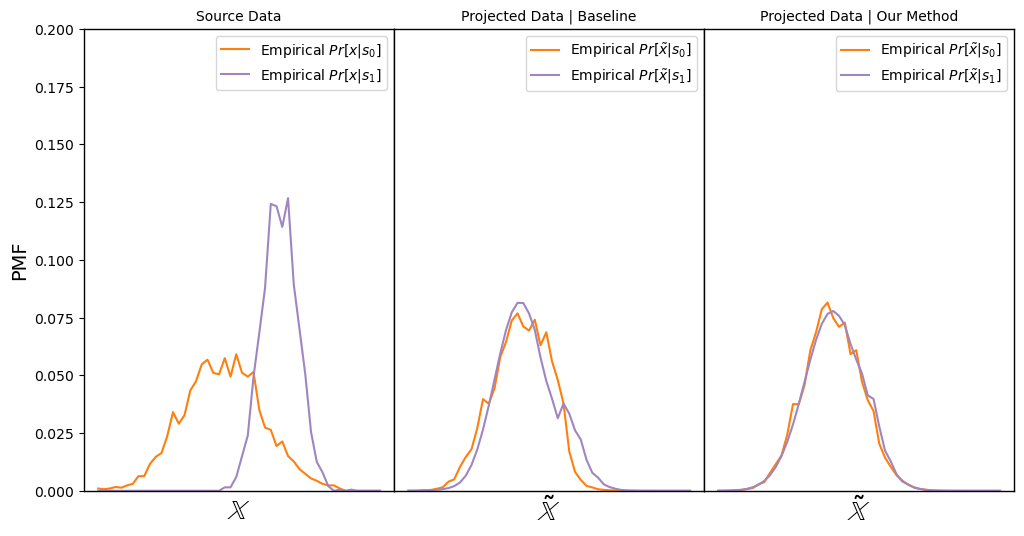

In [447]:
ymax=0.2
fig = plt.figure(figsize=(12,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,3),(0,0), rowspan=1, colspan=1)
dist_tmp=dist_original
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $Pr[x|s_0]$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $Pr[x|s_1]$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend()
plt.xticks([])
plt.xlabel(r'$\mathbb{X}$',fontsize=20)
plt.ylabel('PMF',fontsize=14)
plt.title('Source Data',fontsize=10)
ax=plt.subplot2grid((1,3),(0,1), rowspan=1, colspan=1)
dist_tmp=dist_project_1
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $Pr[\tilde{x}|s_0]$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $Pr[\tilde{x}|s_1]$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend()
plt.yticks([])
plt.xticks([])
plt.xlabel(r'$\tilde{\mathbb{X}}$',fontsize=20)
plt.title('Projected Data | Baseline',fontsize=10)
ax=plt.subplot2grid((1,3),(0,2), rowspan=1, colspan=1)
dist_tmp=dist_project_2
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $Pr[\tilde{x}|s_0]$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $Pr[\tilde{x}|s_1]$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend()
plt.yticks([])
plt.xticks([])
plt.xlabel(r'$\tilde{\mathbb{X}}$',fontsize=20)
plt.title('Projected Data | Our Method',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
plt.savefig('C:/Users/zhouq/Downloads/groupwise.pdf',bbox_inches = 'tight')

In [270]:
def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(3,3))
    gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    ax.set_xlabel(r'$\mathbb{X}$',fontsize=14)
    ax.set_ylabel(r'$\tilde{\mathbb{X}}$',rotation='horizontal',fontsize=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx.set_title(r'$Pr[x]$',rotation='horizontal')
    #ax_histy.set_title(r'$Pr[\tilde{x}]$')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.plot(x_range,g,color='tab:blue')
    ax_histy.plot(f,x_range,color='tab:green') 
    return fig

In [418]:
out=gamma_dict[len(gamma_dict)-1]
out=gamma_classic[len(gamma_classic)-1]

In [419]:
sum(abs(out @ bbm1 - px))

matrix([[0.00036856]])

In [420]:
sum(abs(out.T @ bbm1 - ptx))

matrix([[4.39850857e-16]])

In [421]:
sum(abs(out.T @ V ))

matrix([[0.23971821]])

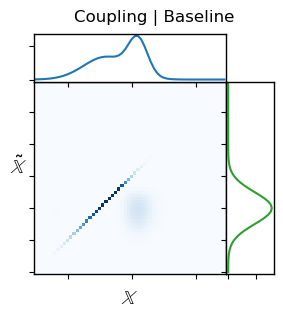

In [424]:
fig=plots(x_range,dist['x'],dist['t_x'],gamma_classic[len(gamma_classic)-1].T.A1.reshape((bin,bin)))
fig.suptitle('Coupling | Baseline')
plt.savefig('C:/Users/zhouq/Downloads/coupling_base.pdf',bbox_inches = 'tight')

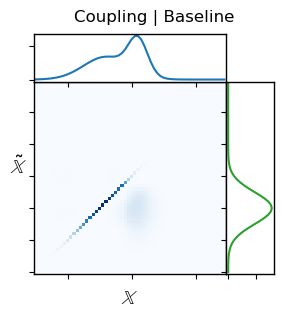

In [423]:
fig=plots(x_range,dist['x'],dist['t_x'],gamma_dict[len(gamma_dict)-1].T.A1.reshape((bin,bin)))
fig.suptitle('Coupling | Baseline')
plt.savefig('C:/Users/zhouq/Downloads/coupling_our.pdf',bbox_inches = 'tight')

In [9]:
dist=dict()
dist['s']=np.array([0.6,0.4])
dist['x_0']= (1/n)*np.ones(n)
dist['x_1']= np.concatenate(((1/(n-2))*np.ones(n-2),np.zeros(2)),axis=None)
dist['x']=dist['s'][0]*dist['x_0']+dist['s'][1]*dist['x_1']
dist['t_x']= (1/n)*np.ones(n)

In [10]:
v=(dist['x_0']-dist['x_1'])/dist['x']

In [11]:
e=0.01

sum(gamma) == gamma.T \mathbb{1}

sum(gamma.T) == gamma \mathbb{1}

In [118]:
xi=xi_generate([*range(bin)],e)

In [14]:
theta=abs(gamma.T @ v)*(1-0.3)

In [93]:
I=np.where(~(v==0))[0].tolist() # \overline{\supp(X)}
bbm1=np.matrix(np.ones(n)).T
px=np.matrix(dist['x']).T
ptx=np.matrix(dist['t_x']).T
V=np.matrix(v).T
Ve=np.multiply(V,np.exp(V))
#theta=np.matrix(abs(gamma.T @ v)*(1-0.3)).T
gamma_dict=dict()
gamma_dict[0]=np.matrix(xi+0.01)
gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
# step 3
J=np.where(~((np.matrix(gamma_dict[2]).T @ np.matrix(v).T).A1 ==0))[0].tolist()
nu=np.zeros(n)
gamma_dict[3]=np.copy(gamma_dict[2])
for j in J:
    fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
    nu = bisection(fun, -5, 5, stepmax = 25, tol = 1.0e-3)
    for i in I:
        gamma_dict[3][i,j]=np.exp(nu*V.item(i))*gamma_dict[2].item(i,j)
gamma_dict[3]=np.matrix(gamma_dict[3])

#=========================
L=3
q_dict=dict()
for loop in range(1,50):
    tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
    gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

    tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
    gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

    # step 3
    tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
    J=np.where(~((np.matrix(tmp).T @ np.matrix(v).T).A1 ==0))[0].tolist()
    gamma_dict[loop*L+3]=np.copy(tmp)
    for j in J:
        fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
        nu = bisection(fun, -5, 5, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[loop*L+3][i,j]=np.exp(nu*V.item(i))*tmp.item(i,j)
    gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])


In [152]:
gamma_dict

{0: matrix([[1.00000e-02, 1.00010e+02, 2.00010e+02, ..., 4.70001e+03,
          4.80001e+03, 4.90001e+03],
         [1.00010e+02, 1.00000e-02, 1.00010e+02, ..., 4.60001e+03,
          4.70001e+03, 4.80001e+03],
         [2.00010e+02, 1.00010e+02, 1.00000e-02, ..., 4.50001e+03,
          4.60001e+03, 4.70001e+03],
         ...,
         [4.70001e+03, 4.60001e+03, 4.50001e+03, ..., 1.00000e-02,
          1.00010e+02, 2.00010e+02],
         [4.80001e+03, 4.70001e+03, 4.60001e+03, ..., 1.00010e+02,
          1.00000e-02, 1.00010e+02],
         [4.90001e+03, 4.80001e+03, 4.70001e+03, ..., 2.00010e+02,
          1.00010e+02, 1.00000e-02]]),
 1: matrix([[1.99959694e-11, 1.99979690e-07, 3.99939384e-07, ...,
          9.39812561e-06, 9.59808531e-06, 9.79804500e-06],
         [3.22777480e-07, 3.22745206e-11, 3.22777480e-07, ...,
          1.48463117e-05, 1.51690569e-05, 1.54918022e-05],
         [1.02075126e-06, 5.10401145e-07, 5.10350110e-11, ...,
          2.29658060e-05, 2.34761561e-05, 2.398

In [99]:
#test:

In [153]:
print(gamma_dict[150]@bbm1)
print(px)

[[2.45132037e-04]
 [3.80152792e-04]
 [5.77634570e-04]
 [8.59973480e-04]
 [1.25445139e-03]
 [1.79291425e-03]
 [2.51074216e-03]
 [3.44494030e-03]
 [4.63125001e-03]
 [6.10031065e-03]
 [7.87305242e-03]
 [9.95571110e-03]
 [1.23350314e-02]
 [1.49742743e-02]
 [1.78112227e-02]
 [2.07577505e-02]
 [2.37031029e-02]
 [2.65196801e-02]
 [2.90718403e-02]
 [3.12275851e-02]
 [3.28739693e-02]
 [3.39389538e-02]
 [3.44248950e-02]
 [3.44631874e-02]
 [3.43705360e-02]
 [3.47130595e-02]
 [3.62631715e-02]
 [3.97769472e-02]
 [4.55650193e-02]
 [5.30138245e-02]
 [6.03959049e-02]
 [6.52819663e-02]
 [6.55164916e-02]
 [6.02625441e-02]
 [5.04565180e-02]
 [3.83555872e-02]
 [2.64941838e-02]
 [1.67055739e-02]
 [9.70803590e-03]
 [5.28852856e-03]
 [2.77368948e-03]
 [1.45081592e-03]
 [7.83248418e-04]
 [4.44178340e-04]
 [2.62969925e-04]
 [1.59319778e-04]
 [9.68631129e-05]
 [5.83465208e-05]
 [3.45916745e-05]
 [2.01268355e-05]]
[[2.44951625e-04]
 [3.79872721e-04]
 [5.77208526e-04]
 [8.59338393e-04]
 [1.25352367e-03]
 [1.79158

In [154]:
print(gamma_dict[150].T@bbm1)
print(ptx)

[[2.67660133e-05]
 [5.83893852e-05]
 [1.22380386e-04]
 [2.46443834e-04]
 [4.76817640e-04]
 [8.86369682e-04]
 [1.58308917e-03]
 [2.71659385e-03]
 [4.47890273e-03]
 [7.09491829e-03]
 [1.07981858e-02]
 [1.57900299e-02]
 [2.21841669e-02]
 [2.99454729e-02]
 [3.88372110e-02]
 [4.83941449e-02]
 [5.79383106e-02]
 [6.66449206e-02]
 [7.36540281e-02]
 [7.82085388e-02]
 [7.97884561e-02]
 [7.82085388e-02]
 [7.36539770e-02]
 [6.66449206e-02]
 [5.79383106e-02]
 [4.83941449e-02]
 [3.88372110e-02]
 [2.99454570e-02]
 [2.21841669e-02]
 [1.57900168e-02]
 [1.07981933e-02]
 [7.09491857e-03]
 [4.47890239e-03]
 [2.71659385e-03]
 [1.58309004e-03]
 [8.86369682e-04]
 [4.76817426e-04]
 [2.46443834e-04]
 [1.22380247e-04]
 [5.83893852e-05]
 [2.67660452e-05]
 [1.17886136e-05]
 [4.98849426e-06]
 [2.02816798e-06]
 [7.92259818e-07]
 [2.97343866e-07]
 [1.07220707e-07]
 [3.71472369e-08]
 [1.23652410e-08]
 [3.95463928e-09]]
[[2.67660452e-05]
 [5.83893852e-05]
 [1.22380386e-04]
 [2.46443834e-04]
 [4.76817640e-04]
 [8.86369

In [155]:
print(gamma_dict[150].T@V)

[[ 9.94342971e-09]
 [-3.65463183e-08]
 [-2.63056915e-08]
 [-3.10243393e-07]
 [-6.09003392e-07]
 [-4.56186772e-07]
 [ 1.17717651e-06]
 [-1.34709396e-06]
 [ 3.22336097e-06]
 [ 9.16714411e-06]
 [ 8.08921627e-06]
 [ 1.93453104e-05]
 [-8.82411258e-06]
 [ 2.24338875e-05]
 [-2.29077022e-05]
 [-5.23689256e-05]
 [-6.08406375e-05]
 [-3.39042104e-05]
 [-3.49730303e-06]
 [-2.10540385e-05]
 [-3.77356817e-05]
 [ 2.32683293e-06]
 [ 6.20842718e-05]
 [ 1.80762057e-06]
 [-5.23957758e-05]
 [ 1.45400365e-05]
 [ 1.19393756e-05]
 [ 1.96495624e-05]
 [-1.38967241e-05]
 [ 1.39895821e-05]
 [-5.07096957e-06]
 [-8.25580816e-06]
 [ 3.21268024e-06]
 [-1.07959647e-06]
 [ 1.76740085e-06]
 [-7.92644507e-07]
 [ 4.44923877e-07]
 [-2.58612986e-07]
 [ 5.02487586e-08]
 [-5.14428905e-08]
 [-3.03666456e-08]
 [-1.39383286e-08]
 [-4.75406117e-09]
 [ 7.74026458e-10]
 [-1.01271482e-09]
 [ 3.76981610e-10]
 [-1.01341681e-10]
 [-1.03846806e-11]
 [ 8.93284352e-13]
 [-9.94768233e-13]]


In [ ]:

def algorithms(reg,m,n,g,f,C):
    K=np.exp(-C/C.max()/reg)
    interations=100
    trial=10 #check the optimiality every trial. 
    u=np.ones((n,1))
    u_record=np.ones((n,1))
    for tri in range(trial):
        if sum(abs(u_record-u))<10**(-10):
            for i in range(1,interations):
                v=g/np.dot(K.T,u)
                u=f/np.dot(K,v)
            u_record=u
        else:
            break
    return np.dot(np.diag(u.reshape((1,-1))[0]),np.dot(K,np.diag(v.reshape((1,-1))[0])))

def assess(m,n,g,f,C,output):
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f.reshape(n))))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g.reshape(m))))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(3,3))
    gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    ax.set_xlabel(r'$\mathbb{X}$',fontsize=14)
    ax.set_ylabel(r'$\tilde{\mathbb{X}}$',rotation='horizontal',fontsize=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx.set_title(r'$Pr[x]$',rotation='horizontal')
    #ax_histy.set_title(r'$Pr[\tilde{x}]$')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.plot(x_range,g,color='tab:blue')
    ax_histy.plot(f,x_range,color='tab:green') 
    return fig

def OT(reg,x_range,g,f):
    m=len(g)
    n=len(f)
    C=c_generate(x_range)
    output=algorithms(reg,m,n,g.reshape(m,-1),f.reshape(n,-1),C)
    assess(m,n,g,f,C,output)
    plots(x_range,g,f,output)
    return outputa